In [ ]:
# Soil Image Classification: Challenge 2
# https://www.kaggle.com/competitions/soil-classification-part-2

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from PIL import UnidentifiedImageError, Image
from pathlib import Path


from collections import defaultdict

In [2]:
import seaborn as snsu

In [3]:
# Step 3: Mount Google Drive or upload data via Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ==== CONFIG ==== #



TRAIN_DIR = Path('/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/train')
TEST_DIR = Path('/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/test')

train_csv = '/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/train_labels.csv'
test_csv = '/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/test_ids.csv'




train_df = pd.read_csv(train_csv)

In [5]:
#List of files in TEST_DIR and to extarct Unique file extensions
test_files = os.listdir(TEST_DIR)

extensions = [os.path.splitext(f)[1].lower().replace(".", "") for f in test_files if os.path.isfile(os.path.join(TEST_DIR, f))]

# Count and display unique types
ext_counts = Counter(extensions)
print(" Unique image file types in test set:")
for ext, count in ext_counts.items():
    print(f" {ext}: {count} file(s)")


 Unique image file types in test set:
 jpg: 967 file(s)


In [ ]:
# List of files in TRAIN_DIR to extract Unique file extensions
train_files = os.listdir(TRAIN_DIR)

extensions = [os.path.splitext(f)[1].lower().replace(".", "") for f in train_files if os.path.isfile(os.path.join(TRAIN_DIR, f))]

# Count unique types
ext_counts = Counter(extensions)
print(" Unique image file types in training set:")
for ext, count in ext_counts.items():
    print(f"{ext}: {count} file(s)")


 Unique image file types in training set:
jpg: 1116 file(s)
jpeg: 92 file(s)
png: 6 file(s)
webp: 6 file(s)
gif: 2 file(s)


In [ ]:
#Extratcing file name of special types (png, webp and gif for analysis)
import os

def list_specific_file_types(directory, extensions_to_find):
    files = os.listdir(directory)
    filtered_files = [f for f in files if os.path.isfile(os.path.join(directory, f))
                      and os.path.splitext(f)[1].lower().replace('.', '') in extensions_to_find]
    return filtered_files

target_extensions = {'png', 'webp', 'gif'}

train_specific_files = list_specific_file_types(TRAIN_DIR, target_extensions)
test_specific_files = list_specific_file_types(TEST_DIR, target_extensions)

# Display results
print(" Train images with png, webp, or gif extensions:")
for fname in train_specific_files:
    print("•", fname)

print("\n Test images with png, webp, or gif extensions:")
for fname in test_specific_files:
    print("•", fname)


 Train images with png, webp, or gif extensions:
• img_3050f4cb.png
• img_4bdf66f2.png
• img_622d25fd.webp
• img_60f71041.png
• img_850f28ec.webp
• img_831af63a.png
• img_923fc79a.gif
• img_9bf4b58d.webp
• img_a7aecb27.png
• img_b46efa76.png
• img_e15cf9ad.webp
• img_e2e8afd0.webp
• img_ed9ba5bd.gif
• img_2d5911bd.webp

 Test images with png, webp, or gif extensions:


In [ ]:
# 3. Image resolution stats
def get_image_dims(path_list):
    dims = []
    for file in path_list:
        try:
            with Image.open(file) as img:
                dims.append(img.size)
        except:
            continue
    return pd.DataFrame(dims, columns=["width", "height"])

train_files = list(TRAIN_DIR.glob("*"))
test_files = list(TEST_DIR.glob("*"))

train_dims_df = get_image_dims(train_files)
test_dims_df = get_image_dims(test_files)

# Outputs for visualization
(train_dims_df.describe(), test_dims_df.describe())


(             width       height
 count  1222.000000  1222.000000
 mean    628.774959   403.273322
 std     435.308120   260.160161
 min     100.000000    57.000000
 25%     266.000000   183.250000
 50%     453.500000   295.000000
 75%    1160.000000   522.000000
 max    2592.000000  1920.000000,
              width       height
 count   967.000000   967.000000
 mean    289.029990   249.710445
 std     239.197061   164.941382
 min     100.000000    57.000000
 25%     224.000000   224.000000
 50%     224.000000   224.000000
 75%     259.000000   224.000000
 max    2592.000000  1920.000000)

In [ ]:
#Function to visulaize dataset (train/test)

def analyze_image_folder(folder_path, dataset_name="Dataset"):
    formats_count = defaultdict(int)
    dimensions = []
    file_sizes = []
    corrupt_files = []

    folder_path = Path(folder_path)

    # 🧪 Analyze each image
    for img_path in folder_path.iterdir():
        try:
            with Image.open(img_path) as img:
                formats_count[img.format.lower()] += 1
                dimensions.append(img.size)
                file_sizes.append(os.path.getsize(img_path))
        except UnidentifiedImageError:
            corrupt_files.append(img_path.name)

    # Skip analysis if no images were read
    if not dimensions:
        print(f"❌ No valid images found in {dataset_name}")
        return

    # 📈 Convert to arrays
    widths, heights = zip(*dimensions)
    aspect_ratios = np.array(widths) / np.array(heights)

    print(f"\n📂 {dataset_name} Analysis")
    print(f"⚠️ Corrupt/Unreadable Files: {len(corrupt_files)}")
    if corrupt_files:
        print("Corrupt file names:", corrupt_files)


    print(f"• Aspect Ratio: min={aspect_ratios.min():.2f}, max={aspect_ratios.max():.2f}")
    print(f"• File Size (KB): min={np.min(file_sizes)/1024:.1f}, max={np.max(file_sizes)/1024:.1f}, mean={np.mean(file_sizes)/1024:.1f}")

    return widths, heights, aspect_ratios, file_sizes


In [ ]:
# TEST DATA Visualization + File size analysis

# Analyze Test Data
test_widths, test_heights, test_aspect_ratios, test_file_sizes = analyze_image_folder(TEST_DIR, dataset_name="Test Set")

# 📊 Plot: Width and Height Distribution (Side-by-side)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Width distribution
sns.histplot(test_widths, bins=20, ax=ax[0], kde=True, color="skyblue")
ax[0].set_title("Image Width Distribution")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_xticks([0, 512, 1024, 1536, 2048, 2560])

# Height distribution
sns.histplot(test_heights, bins=20, ax=ax[1], kde=True, color="salmon")
ax[1].set_title("Image Height Distribution")
ax[1].set_xlabel("Height (pixels)")
ax[1].set_ylabel("Count")
ax[1].set_xticks([0, 512, 1024, 1536, 2048, 2560])

plt.tight_layout()
plt.show()


# 📊 Plot: Aspect Ratio
plt.figure(figsize=(8, 4))
sns.histplot(test_aspect_ratios, bins=30, kde=True, color="violet")
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
# Train DATA Visualization + File size analysis

# Analyze 

train_widths, train_heights, train_aspect_ratios, train_file_sizes = analyze_image_folder(TRAIN_DIR, dataset_name="Train Set")

# 📊 Plot: Width and Height Distribution (Side-by-side)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Width distribution
sns.histplot(train_widths, bins=20, ax=ax[0], kde=True, color="skyblue")
ax[0].set_title("Train Image Width Distribution")
ax[0].set_xlabel("Width (pixels)")
ax[0].set_ylabel("Count")
ax[0].set_xticks([0, 512, 1024, 1536, 2048, 2560])

# Height distribution
sns.histplot(train_heights, bins=20, ax=ax[1], kde=True, color="salmon")
ax[1].set_title("Train Image Height Distribution")
ax[1].set_xlabel("Height (pixels)")
ax[1].set_ylabel("Count")
ax[1].set_xticks([0, 512, 1024, 1536, 2048, 2560])

plt.tight_layout()
plt.show()


# 📊 Plot: Aspect Ratio
plt.figure(figsize=(8, 4))
sns.histplot(train_aspect_ratios, bins=30, kde=True, color="violet")
plt.title("Train Image Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.tight_layout()
plt.show()

In [ ]:
#torch.save(model.state_dict(), "best_model_challeneg 2.pth")
#saving model weights only

In [ ]:
#torch.save(model, "best_model_full_challenge_2.pt")

#saving complete model (architecture+weights)


In [ ]:
#Point to run

In [ ]:
# Directory Structure based on your checklist
# .
# ├── /src/
# │   └── model.py
# ├── /notebooks/
# │   ├── training.ipynb
# │   └── inference.ipynb
# ├── /docs/
# │   ├── architecture.png
# │   └── /cards/
# │       ├── project-card.ipynb
# │       └── ml-metrics.json
# ├── /data/
# │   └── download.sh
# ├── README.md
# ├── requirements.txt

# Example content for src/model.py

In [ ]:
# Soil vs Non-Soil Classification
# Autoencoder-based Anomaly Detection using pretrained ResNet18 Encoder

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve

# ==== 1. Setup device ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==== 2. Dataset ====

class SoilDataset(Dataset):
    def __init__(self, img_dir, labels_csv=None, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        if labels_csv:
            self.df = pd.read_csv(labels_csv)
            # Assuming columns: 'image_id', 'label'
            self.img_names = self.df['image_id'].values
            self.labels = self.df['label'].values
        else:
            self.img_names = sorted(os.listdir(img_dir))
            self.labels = None  # unlabeled or only positives

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

# ==== 3. Transforms ====
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])   # ImageNet stds
])

Using device: cpu


In [ ]:

TRAIN_DIR = Path('/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/train')
TEST_DIR = Path('/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/test')

train_csv = '/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/train_labels.csv'
test_csv = '/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/test_ids.csv'


In [ ]:

# ==== 4. Load Data ====


TRAIN_DIR = Path('/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/train')

TRAIN_LABELS_CSV = "/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/train_labels.csv"

# Load dataset (only soil images labeled 1)
full_dataset = SoilDataset(TRAIN_DIR, TRAIN_LABELS_CSV, transform=transform)

# Filter only soil images (label == 1) for training autoencoder
soil_indices = [i for i, (_, label) in enumerate(full_dataset) if label == 1]
soil_dataset = torch.utils.data.Subset(full_dataset, soil_indices)

# Split into train/val for early stopping and threshold selection (80/20)
train_size = int(0.8 * len(soil_dataset))
val_size = len(soil_dataset) - train_size
train_dataset, val_dataset = random_split(soil_dataset, [train_size, val_size])

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Train samples: 977, Validation samples: 245


In [ ]:
# ==== 5. Model Definition ====

import torch
import torch.nn as nn
import torchvision.models as models

class Autoencoder224(nn.Module):
    def __init__(self):
        super(Autoencoder224, self).__init__()

        # Use pretrained ResNet18 as encoder backbone
        base_model = models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(base_model.children())[:-2])  # Output: (512, 7, 7)

        # Decoder to upscale back to 224x224
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # (256, 14, 14)
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (128, 28, 28)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # (64, 56, 56)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # (32, 112, 112)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),    # (16, 224, 224)
            nn.ReLU(True),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),              # (3, 224, 224)
            nn.Sigmoid()  # keep pixel values in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder224().to(device)
print(model)


Autoencoder224(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:


# ==== 6. Loss and Optimizer ====

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
num_epochs = 8
learning_rate = 1e-3

# Loss function & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Enable early stopping
best_loss = float('inf')
patience = 1
patience_counter = 0

train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # tqdm progress bar
    for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs = imgs.to(device)

        # Forward pass
        outputs = model(imgs)

        # Make sure output and input sizes match
        if outputs.shape != imgs.shape:
            print(f"Skipping batch due to shape mismatch: {outputs.shape} vs {imgs.shape}")
            continue

        loss = criterion(outputs, imgs)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_autoencoder.pth')  # Save best model
        print("✅ Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


Epoch 1/8: 100%|██████████| 31/31 [07:57<00:00, 15.39s/it]


Epoch [1/8], Loss: 1.036991
✅ Model saved.


Epoch 2/8: 100%|██████████| 31/31 [07:43<00:00, 14.94s/it]


Epoch [2/8], Loss: 1.017666
✅ Model saved.


Epoch 3/8: 100%|██████████| 31/31 [07:36<00:00, 14.73s/it]


Epoch [3/8], Loss: 0.970975
✅ Model saved.


Epoch 4/8: 100%|██████████| 31/31 [07:35<00:00, 14.70s/it]


Epoch [4/8], Loss: 0.939571
✅ Model saved.


Epoch 5/8: 100%|██████████| 31/31 [07:20<00:00, 14.22s/it]


Epoch [5/8], Loss: 0.933727
✅ Model saved.


Epoch 6/8: 100%|██████████| 31/31 [07:09<00:00, 13.86s/it]


Epoch [6/8], Loss: 0.923680
✅ Model saved.


Epoch 7/8: 100%|██████████| 31/31 [07:06<00:00, 13.74s/it]

Epoch [7/8], Loss: 0.923887
⏹️ Early stopping triggered.


In [ ]:
# ==== 8. Load Best Model ====
model.load_state_dict(torch.load('best_autoencoder.pth'))
model.eval()


Autoencoder224(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
# ==== 9. Threshold Selection on Validation Set ====

val_reconstruction_errors = []

with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        errors = torch.mean((outputs - imgs) ** 2, dim=[1, 2, 3])  # MSE per sample
        val_reconstruction_errors.extend(errors.cpu().numpy())

val_reconstruction_errors = np.array(val_reconstruction_errors)
print("Validation Reconstruction Error Stats:")
print(f"Mean: {val_reconstruction_errors.mean():.6f}, Max: {val_reconstruction_errors.max():.6f}")

# Set threshold slightly above max reconstruction error on soil images
threshold = val_reconstruction_errors.max() * 1.05
print(f"Chosen threshold for anomaly detection: {threshold:.6f}")



Validation Reconstruction Error Stats:
Mean: 0.937379, Max: 3.417062
Chosen threshold for anomaly detection: 3.587914


In [ ]:
class TestSoilDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['image_id']
        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, image_name  # return name for submission mapping


In [ ]:
# ==== 10. Load Test Data ====

from pathlib import Path

TEST_DIR = Path('/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/test')
TEST_CSV = '/content/drive/MyDrive/soil-classification-part-2/soil_competition-2025/test_ids.csv'


#test_dataset = SoilDataset(TEST_DIR, TEST_CSV, transform=transform)

test_dataset = TestSoilDataset(TEST_DIR, TEST_CSV, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



In [ ]:
model.eval()
reconstruction_errors = []
image_names = []

with torch.no_grad():
    for imgs, names in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = torch.mean((outputs - imgs) ** 2, dim=[1, 2, 3])  # per-image MSE
        reconstruction_errors.extend(loss.cpu().numpy())
        image_names.extend(names)


KeyboardInterrupt: 

In [ ]:
# ==== 11. Prediction on Test Set ====

predictions = []
image_ids = []

# Get image ids from test CSV
test_df = pd.read_csv(TEST_CSV)
image_ids = test_df['image_id'].values

model.eval()
with torch.no_grad():
    for imgs, names in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        errors = torch.mean((outputs - imgs) ** 2, dim=[1, 2, 3])
        batch_pred = (errors <= threshold).long().cpu().numpy()  # 1 = soil, 0 = non-soil
        predictions.extend(batch_pred)

# ✅ Assert after predictions are computed
assert len(image_ids) == len(predictions), f"Expected {len(image_ids)} predictions but got {len(predictions)}"

# Create submission DataFrame
submission_df = pd.DataFrame({'image_id': image_ids, 'label': predictions})
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")


Submission file saved as submission.csv


In [ ]:
# ==== 12. Save Predictions CSV ====

submission_df = pd.DataFrame({
    'image_id': image_ids,
    'label': predictions
})

submission_df.to_csv("soil_vs_nonsoil_predictions.csv", index=False)
print("Saved prediction CSV: soil_vs_nonsoil_predictions.csv")

Saved prediction CSV: soil_vs_nonsoil_predictions.csv


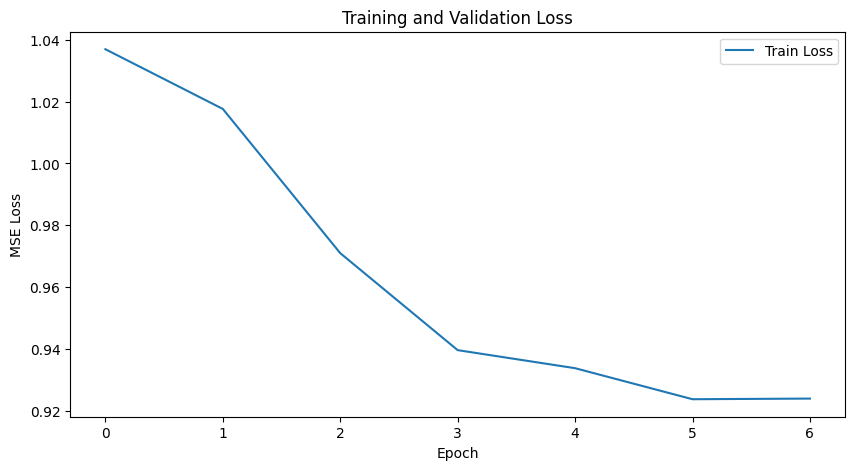

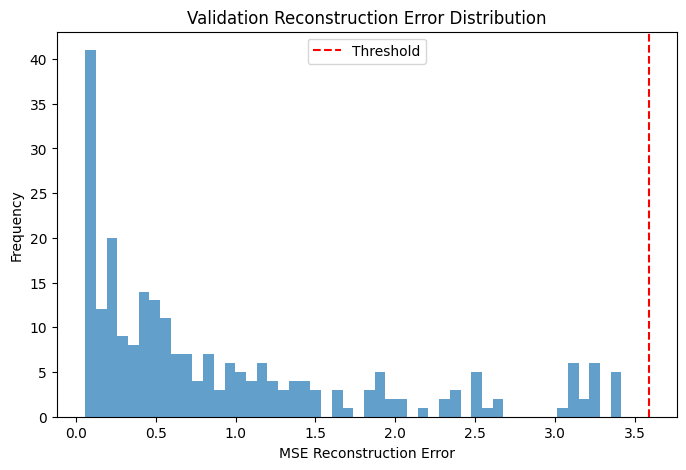

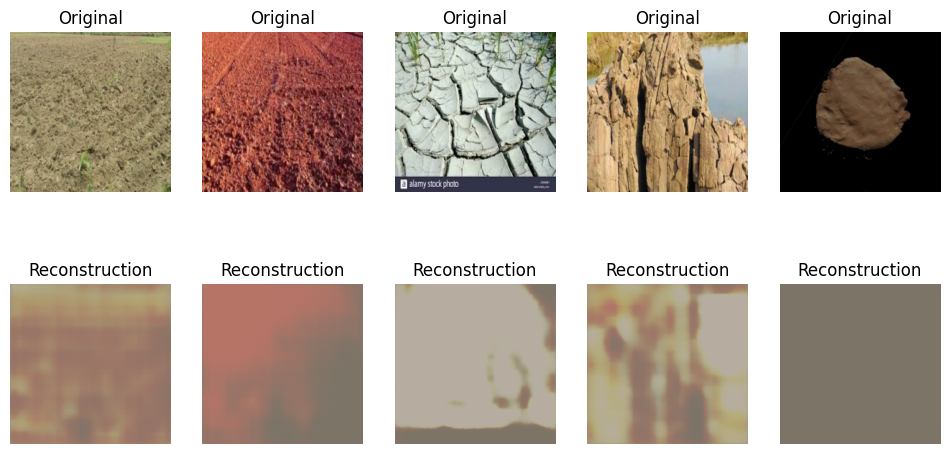

In [ ]:


# ==== 13. Visualizations ====

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
#plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Histogram of reconstruction errors on validation soil images
plt.figure(figsize=(8,5))
plt.hist(val_reconstruction_errors, bins=50, alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("Validation Reconstruction Error Distribution")
plt.xlabel("MSE Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize some reconstructions from val set
def imshow(img_tensor):
    img = img_tensor.cpu().numpy().transpose(1,2,0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # denormalize
    img = np.clip(img, 0, 1)
    return img

num_samples = 5
val_iter = iter(val_loader)
imgs, _ = next(val_iter)
imgs = imgs.to(device)
with torch.no_grad():
    outputs = model(imgs)

plt.figure(figsize=(12,6))
for i in range(num_samples):
    # Original
    plt.subplot(2, num_samples, i+1)
    plt.imshow(imshow(imgs[i]))
    plt.title("Original")
    plt.axis('off')
    # Reconstruction
    plt.subplot(2, num_samples, i+1+num_samples)
    plt.imshow(imshow(outputs[i]))
    plt.title("Reconstruction")
    plt.axis('off')
plt.show()